## ReAct Agent using LangGraph

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name = "llama-3.3-70b-versatile")

In [4]:
llm.invoke("Hi do you think I am a good person?")

AIMessage(content='That\'s a thoughtful question. I don\'t have personal opinions, but I can tell you that being a "good person" is subjective and can vary depending on individual perspectives and values. What one person considers "good," another person might not.\n\nInstead of making a judgment, I\'d like to ask: What makes you wonder if you\'re a good person? Is there something specific that\'s been on your mind, or are you looking for reassurance? I\'m here to listen and offer support if you\'d like to talk about it.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 45, 'total_tokens': 154, 'completion_time': 0.304293166, 'prompt_time': 0.011398079, 'queue_time': 0.931466895, 'total_time': 0.315691245}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--b6522914-c2f1-408c-9936-bdee92debf39-0', usage_metadata={'input_tokens

In [5]:
from langgraph.graph import MessagesState, StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.tools import tool
from langgraph.graph.message import add_messages


In [6]:
@tool
def multiply(a: int, b: int) -> int:
    """ Multiply the two numbers a and b and return the result """
    return a*b

In [7]:
@tool
def add(a: int, b: int) -> int:
    """ Add the two numbers a and b and return the result """
    return a+b

In [8]:
@tool
def divide(a: int, b: int) -> int:
    """ Divide a by b and return return the result """
    return a / b

In [9]:
from langchain_community.utilities import GoogleSerperAPIWrapper
serper = GoogleSerperAPIWrapper()

In [10]:
@tool
def web_search(query: str) -> str:
     """ This is a websearch tool functionality which lets the Agent search the internet if the user desires so"""
     return serper.run(query)

In [11]:
tools = [add, multiply, divide, web_search]

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [13]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [14]:
def reasoner(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [15]:
builder = StateGraph(MessagesState)

In [16]:
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools))

In [17]:
builder.add_edge(START, "reasoner")

In [18]:
builder.add_conditional_edges(
    "reasoner",
    tools_condition,
)

In [19]:
builder.add_edge("tools", "reasoner")

In [20]:
react_graph = builder.compile()

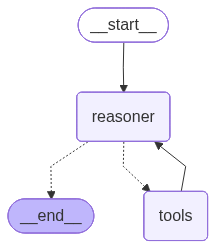

In [21]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [22]:
message = [HumanMessage(content="What is 2 times of age of Max Verstappen?")]

In [23]:
messsages = react_graph.invoke({"messages": message})

In [24]:
for m in messsages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of age of Max Verstappen?
================================== Ai Message ==================================
Tool Calls:
  web_search (a4ne12kh6)
 Call ID: a4ne12kh6
  Args:
    query: Max Verstappen age
================================= Tool Message =================================
Name: web_search

Max Verstappen. Verstappen at the 2024 Dutch Grand Prix. Born. Max Emilian Verstappen. (1997-09-30) 30 September 1997 (age 27). Hasselt, Limburg, Belgium. MaxVerstappen ; Pole Positions: 45 ; World Championships: 4 ; DNFs: 33 ; Date of Birth: 30/09/1997 ; Place of Birth: Hasselt, Belgium. In full: Max Emilian Verstappen ; Born: September 30, 1997, Hasselt, Belgium (age 27) ; Awards And Honors: Formula One racing (2023) · Formula One ... Max Verstappen. Verstappen at the 2024 Dutch Grand Prix. Born, Max Emilian Verstappen (1997-09-30) 30 September 1997 (age 27) Hasselt, Belgium · Formula One ...

In [27]:
message = [HumanMessage(content="can you add the age of Cristiano Ronaldo and Lionel Messi?")]

In [28]:
messsages = react_graph.invoke({"messages": message})

In [29]:
for m in messsages['messages']:
    m.pretty_print()

================================ Human Message =================================

can you add the age of Cristiano Ronaldo and Lionel Messi?
================================== Ai Message ==================================
Tool Calls:
  web_search (zk2spdcwj)
 Call ID: zk2spdcwj
  Args:
    query: Cristiano Ronaldo age Lionel Messi age
================================= Tool Message =================================
Name: web_search

Ronaldo is two years older than Messi, and as such two years deeper into his career. But how did his stats at the age of 35 compare to his era-defining rival? Messi and Ronaldo are two years apart, but here you can compare their goals and stat totals at each age! Lionel Messi's record at 38 compared to Cristiano Ronaldo at the same age speaks volumes. Lionel Messi turned 38 on Thursday. Cristiano Ronaldo joined Juventus at age 33 and left at 36 with 101 goals Lionel Messi joined PSG at age 33 and left at 36 with 32 goals ... That means Cristiano is nearly tw

## Creating a Small Finance Bot

In [30]:
import yfinance as yf

@tool
def get_stock_price(ticker: str) -> float:
    """ Gets the price of a stocker using its ticker from Yahoo Finance"""

    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [31]:
get_stock_price("AAPL")

/var/folders/p_/v95prvpj4cz7y53gvmgm1d_r0000gn/T/ipykernel_89320/1558992921.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  get_stock_price("AAPL")


234.35

In [32]:
def reasoner(state):
    query = state["query"]
    messages = state["messages"]

    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")

    message = HumanMessage(content=query)

    messages.append(message)

    result = llm_with_tools.invoke([sys_msg] + messages)

    return {"messages": result}

In [33]:
tools = [add, multiply, divide, web_search, get_stock_price]

In [34]:
llm_with_tools = llm.bind_tools(tools)

In [35]:
class GraphState(TypedDict):
    """ State of the graph """

    query: str
    finance: str
    final_answer: str

    messages: Annotated[list[AnyMessage], operator.add]

In [36]:
workflow = StateGraph(GraphState)

In [37]:
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools))

In [38]:
workflow.add_edge(START, "reasoner")

In [39]:
workflow.add_conditional_edges(
    "reasoner",
    tools_condition,
)

In [40]:
workflow.add_edge("tools", "reasoner")

In [41]:
react_graph2 = workflow.compile()

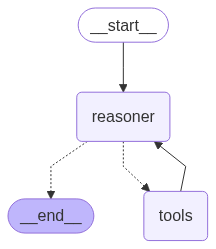

In [42]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))